In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.constants as const
from astropy import units as u
%config InlineBackend.figure_format = 'retina'
import pyneb as pn
import matplotlib
from scipy.ndimage import gaussian_filter1d
from matplotlib.colors import Normalize
from scipy.special import voigt_profile
import math

In [2]:
c = const.c.cgs.value   
k_B = const.k_B.cgs.value  
m_p = const.m_p.cgs.value 
m_H = m_p  # mass of hydrogen atom in grams
m_O = 16 * m_p  # mass of oxygen atom in grams


O3 = pn.Atom(atom = 'O3')  # O3
H1 = pn.RecAtom('H', 1)  # H-beta

In [3]:
def weights(x, y, R, dR = None):
    if dR is None:
        dR = 0.1 * R
    
    rho2 = x**2 + y**2
    Rin, Rout = R - 0.5 * dR, R + 0.5 * dR
    w = np.zeros_like(rho2)

    inside = rho2 < Rout**2
    outs, ins = np.zeros_like(rho2), np.zeros_like(rho2)

    outs[inside] = np.sqrt(Rout**2 - rho2[inside])

    ii = rho2 < Rin**2
    ins[ii] = np.sqrt(Rin**2 - rho2[ii])

    # LOS path length 
    w = 2.0 * (outs - ins)
    return w

def getflux(ion, wl, T, ne, ni = None):
    if ni is None:
        ni = ne * 1e-4 # rough estimate from ISM densities

    eps = ion.getEmissivity(tem=T, den=ne, wave=wl)
    # emissivity per unit volume
    j = eps * ne * ni
    return j

# thermal broadening 
def broaden(wl0, T, mass):
    v_th = np.sqrt(2 * k_B * T / mass)
    return wl0 * (v_th / c)

# line-of-sight velocities for a spherical shell as seen on IFUM
def los_vel(x, y, R, k):
    rho2 = x**2 + y**2
    inside = rho2 <= R**2

    z = np.zeros_like(x, dtype=float)
    z[inside] = np.sqrt(R**2 - rho2[inside]) # near side

    v_rad = k / R

    v_near = np.zeros_like(x, dtype=float)
    v_near[inside] = v_rad * (z[inside] / R)

    v_far = -v_near

    velocities = np.concatenate((v_far, v_near))
    return v_near, v_far, velocities

# gaussian profile
def getgauss(wl, wl0, sigma, flux):
    amp = flux / (np.sqrt(2 * np.pi) * sigma)
    profile = amp * np.exp(-0.5 * ((wl - wl0) / sigma)**2)
    return profile, amp

# doppler shift
def dopplershift(wl0, vel):
   ckm = c / 1e5
   return wl0 * (vel / ckm)

In [4]:
def getspectrum(wl, T, ne, lines, vel, x=None, y=None, R=None, dR=None, static=False):
    wl = np.asarray(wl)
    spectrum = np.zeros_like(wl, dtype=float)
    info = []

    vel = float(vel) * 1e5  # cm/s

    for line in lines:
        ion  = line['ion']
        lam0 = line['wl']
        mass = line['mass']
        ni   = line.get('ni', 1e-4 * ne)

        # emissivity
        j = getflux(ion, lam0, T, ne, ni=ni)

        # geometry
        if (x is not None) and (y is not None) and (R is not None) and (dR is not None):
            weight = weights(x, y, R, dR)
            F = j * weight
        else:
            F = j
        
        # thermal broadening
        sigma_th = broaden(lam0, T, mass)

        # bulk velocity broadening
        sigma_bulk = (lam0 / c) * vel
        sigma = np.sqrt(sigma_th**2 + sigma_bulk**2)
      
        # static lines, no Doppler shift
        if static:
            xprof = wl - lam0
            prof, amp = getgauss(wl, lam0, sigma, F)
            # prof  = F * voigt_profile(xprof, sigma, 1)
            spectrum += prof 

        else:
            # shifted line center
            lam_c = lam0 * (1 + vel / c)

            xprof = wl - lam_c
            prof, amp = getgauss(wl, lam_c, sigma, F)
            # prof  = F * voigt_profile(xprof, sigma, 0.5)
            spectrum += prof

            info.append({
                'wl': lam0,
                'flux': F,
                'sigma': sigma,
            })

    return spectrum, info


In [5]:
# Epanechnikov kernel
def k_E(u):
    return np.where(np.abs(u) <= 1, 0.75 * (1 - u**2), 0.0)

# Universal KDE function
def kde(x_vals, data, h, kernel=k_E):
    return np.array([np.sum(kernel((x - data) / h) / h) / len(data) for x in x_vals])

# This function calculates the x-grid and h value (from Silverman's rule) 
# The x-grid is calculated using the floor and ceiling function values of the min and max of the data 
# The x-grid and h is later used in the KDE function

def kde_setup(array):
    x_kde = np.linspace(math.floor(min(array)) - 20, math.ceil(max(array)) + 20, 1000)
    IQR = np.percentile(array, 75) - np.percentile(array, 25)
    h_silv = 0.9 * min(np.std(array), IQR / 1.34) * (len(array))**(-1/5)
    return x_kde, h_silv

In [ ]:
hex = np.loadtxt('fibers.csv', delimiter=',', skiprows=7, usecols=(5,6), max_rows=552)
x_arr, y_arr = hex[:,0], hex[:,1]

wl = np.linspace(4850, 5050, 5000)

Rlist = [10, 16, 22]  # shell radii
klist = [4500, 2000, 1000]  # velocity scales

near, far, vels = [], [], []
for R, k in zip(Rlist, klist):
    v_near, v_far, v = los_vel(x_arr, y_arr, R, k)
    near.append(v_near) ; far.append(v_far) ; vels.append(v)

idx = 100  # spaxel index
T =  2600 # temperature in K
ne = 30 # electron density in cm^-3

lines = [
    {'ion': O3,  'wl': 4959, 'mass': m_O},
    {'ion': O3,  'wl': 5007, 'mass': m_O},
    {'ion': H1,  'wl': 4861, 'mass': m_H}]


In [ ]:
shells = []

for i in range(len(near)):
    R  = Rlist[i]
    vel = near[i][idx]
    x, y = x_arr[idx], y_arr[idx]

    s, _ = getspectrum(
        wl, T, ne, lines[0:2],
        vel=vel,
        x=x,
        y=y,
        R=R,
        dR = 0.2
    )

    shells.append(s)

spec_tot = np.zeros_like(wl)
for shell in shells:
    spec_tot += shell

static, _ = getspectrum(
        wl, T, ne, lines,
        vel = near[0][idx],
        x = x_arr[idx],
        y = y_arr[idx],
        R = Rlist[0],
        dR = 0.2,
        static=True
    )

In [20]:
hdul = fits.open('data/smc_snr/b0886.norm.dc.fits')
flux = hdul[0].data
hdr = hdul[0].header

if 'CD1_1' in hdr:
    wave = hdr['CRVAL1'] + hdr['CD1_1'] * (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1)
else:
    wave = hdr['CRVAL1'] + hdr['CDELT1'] * (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1)

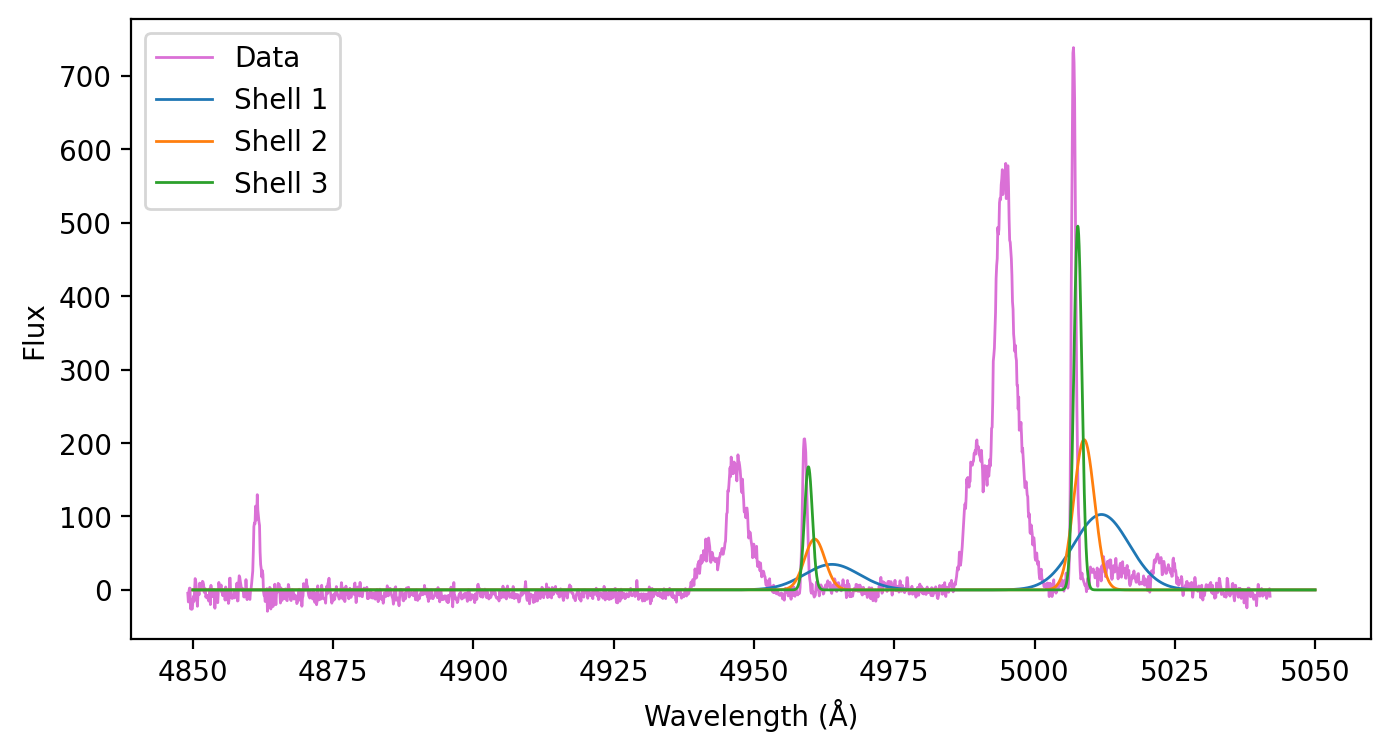

In [30]:
data = flux[idx] - np.median(flux[idx])
norm = np.max(data) / np.max(spec_tot)

z = (5010 - 5007) / 5007 # our data has offset, correcting for that

plt.figure(figsize=(8, 5))

plt.plot(wave / (1 + z), data, label='Data', lw=1, color='orchid')
# plt.plot(wl, static * norm, lw=1, color='orange', label='Static')

for i, s in enumerate(shells):
    plt.plot(wl, s * norm, lw=1, label=f'Shell {i+1}')

# plt.plot(wl, spec_tot * norm, lw = 1, color='k', label='Total')

plt.gca().set_box_aspect(0.5)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')

plt.legend(loc = 'upper left')

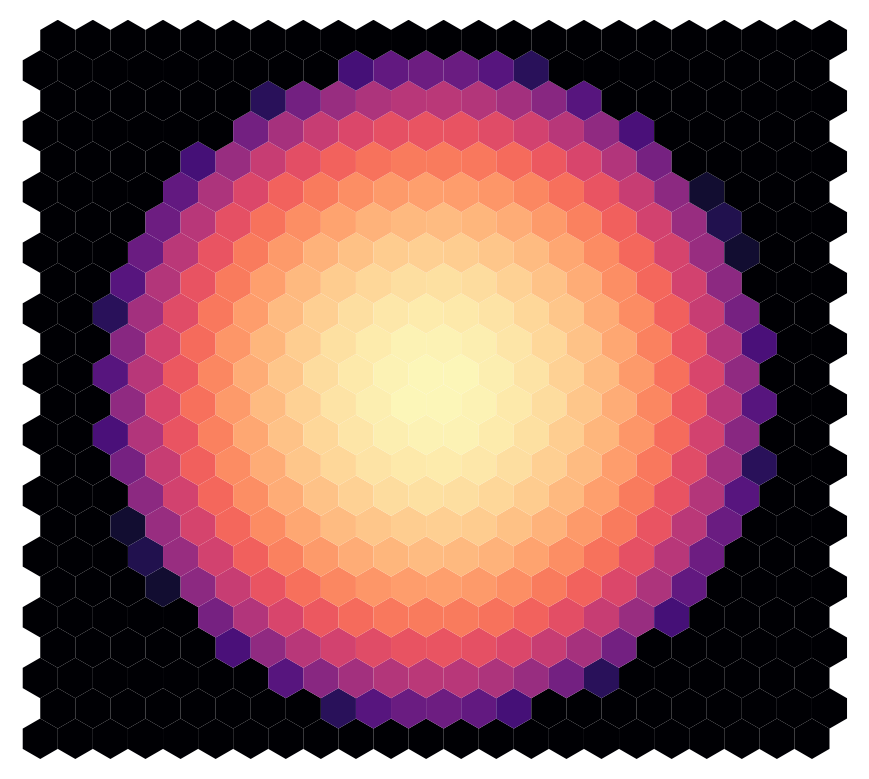

In [23]:
nearsum = near[0]
r = 0.6
cmap = matplotlib.colormaps['magma']
norm = Normalize(vmin=np.percentile(nearsum, 10), vmax=np.percentile(nearsum, 90))

fig,ax=plt.subplots(1,1, dpi=100)
for x,y,i in zip(x_arr, y_arr, range(len(x_arr))):
    color = cmap(norm(nearsum[i]) * 0.9)
    hexag = matplotlib.patches.RegularPolygon((x,y), numVertices=6, radius=r, facecolor=color)
    ax.add_patch(hexag)
    # ax.text(x, y, f'{i+1}', ha='center', va='center', fontsize=6, color='red')  # takes a long time, reduce hexagons to see numbers

ax.set_xlim(np.min(hex[:,0])-r, np.max(hex[:,0])+r)
ax.set_ylim(np.min(hex[:,1])-r, np.max(hex[:,1])+r)
ax.set_aspect('equal'); ax.invert_xaxis()
ax.set_axis_off()

In [ ]:
# velocities = np.concatenate((far, near))

# for i in range(len(vels)):
#     vkde = kde(kde_setup(vels[i])[0], vels[i], kde_setup(vels[i])[1])
#     plt.plot(kde_setup(vels[i])[0], vkde / np.max(vkde), label=f'Shell {i+1}')
# plt.legend()

# vkde = kde(kde_setup(vels[0])[0], vels[0], kde_setup(vels[0])[1])

# plt.plot(kde_setup(vels[0])[0], vkde / np.max(vkde))